In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Prerequisites: Load data

In [2]:
# set up constants

BASE_GENRES = [
    "genre_blues",
    "genre_classical",
    "genre_country",
    "genre_disco",
    "genre_hiphop",
    "genre_jazz",
    "genre_metal",
    "genre_pop",
    "genre_reggae",
    "genre_rock"
]

STRATIFY = ['stratify']

KEY = ['metadata_path']

In [3]:
# load base dataframe

import pandas as pd

filepath = "/content/drive/MyDrive/w207/mids_w207_music_genre/member_workspaces/lawrence/mtg_jamendo_genre_features_base.feather"
df_base = pd.read_feather(filepath)

In [4]:
# split base data into train and test sets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import numpy as np


# get features
FEATURES = list(set(df_base.columns) - set(BASE_GENRES) - set(STRATIFY) - set(KEY))
X = df_base[FEATURES]

# get targets
enc = LabelEncoder()
y = enc.fit_transform(df_base[STRATIFY].values.reshape(-1))

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.2, random_state=10, stratify=y)
  
# X_train, X_valid, y_train, y_valid = \
#     train_test_split(X_train, y_train, test_size=0.25, random_state=10, stratify=y_train)

print(F"X_train: {X_train.shape}")
# print(F"X_valid: {X_valid.shape}")
print(F"X_test:  {X_test.shape}")

# scale
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train, y_train)
# X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)


X_train: (17080, 2739)
X_test:  (4271, 2739)


---

# SVM w/o feature selection

## Experiment \#1: LinearSVC with default parameters

In [5]:
# Experiment #1: 
# Run logistic regression with default parameters

from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score

clf = LinearSVC(class_weight='balanced')
clf.fit(X_train, y_train)

train_accuracy = accuracy_score(y_train, clf.predict(X_train))
# valid_accuracy = accuracy_score(y_valid, clf.predict(X_valid))
test_accuracy = accuracy_score(y_test, clf.predict(X_test))

print(F"Train accuracy: {train_accuracy}")
# print(F"Valid accuracy: {valid_accuracy}")
print(F"Test accuracy:  {test_accuracy}")

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Train accuracy: 0.9260538641686182
Test accuracy:  0.7152891594474362


---
## Experiment \#2: SVC with default parameters

In [6]:
# Experiment #2: 
# Run logistic regression with max # of iterations at 10000

from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

clf = SVC(class_weight='balanced')
clf.fit(X_train, y_train)

train_accuracy = accuracy_score(y_train, clf.predict(X_train))
# valid_accuracy = accuracy_score(y_valid, clf.predict(X_valid))
test_accuracy = accuracy_score(y_test, clf.predict(X_test))

print(F"Train accuracy: {train_accuracy}")
# print(F"Valid accuracy: {valid_accuracy}")
print(F"Test accuracy:  {test_accuracy}")

Train accuracy: 0.8502927400468384
Test accuracy:  0.7438538983844533


---
# SVC with feature selection

## Experiment \#3: SVC with feature selection via random forest

In [12]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=100, 
                             max_depth=500, 
                             random_state=10)
clf.fit(X_train, y_train)
df_feature_importance = pd.DataFrame({"feature_name": FEATURES, 
                                      "feature_importance": clf.feature_importances_})
df_feature_importance.sort_values(by="feature_importance", ascending=False, inplace=True)

In [13]:
"""
Try to use the top n features as determined by random forest model
to train an SVM model
"""
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

tolerance = 10
top_ns = np.arange(10, 510, 10)
train_accuracies = []
test_accuracies = []

for top_n in top_ns:
  top_features = df_feature_importance.head(top_n)['feature_name'].unique()
  feature_indices = [FEATURES.index(f) for f in top_features]

  clf = SVC(class_weight='balanced', max_iter=100000)
  
  clf.fit(X_train[:, feature_indices], y_train)

  train_accuracy = accuracy_score(y_train, clf.predict(X_train[:, feature_indices]))
  train_accuracies.append(train_accuracy)
  test_accuracy = accuracy_score(y_test, clf.predict(X_test[:, feature_indices]))
  test_accuracies.append(test_accuracy)

  print(F"Using the top {top_n} features from random forest model...")
  print(F"Train accuracy: {train_accuracy}")
  print(F"Test accuracy:  {test_accuracy}")
  if train_accuracy > (test_accuracy+0.05):
    print(F"Overfitting detected!")
    if tolerance == 0:
      break
    tolerance -= 1
  else:
    tolerance = 10
  print(F"-"*100)


Using the top 10 features from random forest model...
Train accuracy: 0.3999414519906323
Test accuracy:  0.3942870522125966
----------------------------------------------------------------------------------------------------
Using the top 20 features from random forest model...
Train accuracy: 0.45966042154566744
Test accuracy:  0.45047998126902367
----------------------------------------------------------------------------------------------------
Using the top 30 features from random forest model...
Train accuracy: 0.4697306791569087
Test accuracy:  0.46148442987590726
----------------------------------------------------------------------------------------------------
Using the top 40 features from random forest model...
Train accuracy: 0.4983021077283372
Test accuracy:  0.4898150316085226
----------------------------------------------------------------------------------------------------
Using the top 50 features from random forest model...
Train accuracy: 0.5146955503512881
Test acc

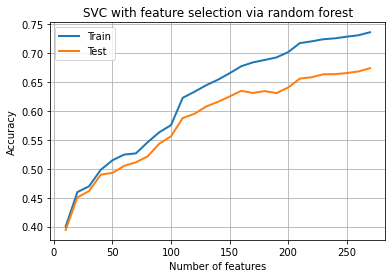

In [17]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(top_ns[:len(train_accuracies)], train_accuracies, linewidth=2.0, label='Train')
ax.plot(top_ns[:len(test_accuracies)], test_accuracies, linewidth=2.0, label='Test')
ax.set_title("SVC with feature selection via random forest")
ax.set_xlabel("Number of features")
ax.set_ylabel("Accuracy")
ax.legend()
ax.grid()
fig.show()

---
## Experiment \#4: SVC with feature selection via Select K Best

In [5]:
"""
Use select K best to select top n features
"""
from sklearn.feature_selection import SelectKBest
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

tolerance = 10
top_ns = np.arange(10, 510, 10)
train_accuracies = []
test_accuracies = []

for top_n in top_ns:

  mask_selected_features = np.full((X_train.shape[1], ), False)
  for i in np.unique(y_train):
    skb = SelectKBest(k=top_n)
    mask = y_train == i
    skb.fit(X_train[mask, :], y_train[mask])
    mask_selected_features |= skb.get_support()
    
  X_train_skb = X_train[:, mask_selected_features]
  X_test_skb = X_test[:, mask_selected_features]

  clf = SVC(class_weight='balanced', max_iter=100000)
  clf.fit(X_train_skb, y_train)

  train_accuracy = accuracy_score(y_train, clf.predict(X_train_skb))
  train_accuracies.append(train_accuracy)
  test_accuracy = accuracy_score(y_test, clf.predict(X_test_skb))
  test_accuracies.append(test_accuracy)

  print(F"Using the top {top_n} features from select k best...")
  print(F"Train accuracy: {train_accuracy}")
  print(F"Test accuracy:  {test_accuracy}")
  if train_accuracy > (test_accuracy+0.05):
    print(F"Overfitting detected!")
    if tolerance == 0:
      break
    tolerance -= 1
  else:
    tolerance = 10
  print(F"-"*100)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWar

Using the top 10 features from select k best...
Train accuracy: 0.39900468384074944
Test accuracy:  0.3764926246780613
----------------------------------------------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWar

Using the top 20 features from select k best...
Train accuracy: 0.48846604215456674
Test accuracy:  0.44134863029735427
----------------------------------------------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWar

Using the top 30 features from select k best...
Train accuracy: 0.5552107728337237
Test accuracy:  0.5062046359166471
----------------------------------------------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWar

Using the top 40 features from select k best...
Train accuracy: 0.5714871194379391
Test accuracy:  0.5218918286115664
----------------------------------------------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWar

Using the top 50 features from select k best...
Train accuracy: 0.596135831381733
Test accuracy:  0.5293842191524233
Overfitting detected!
----------------------------------------------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWar

Using the top 60 features from select k best...
Train accuracy: 0.6164519906323185
Test accuracy:  0.5502224303441817
Overfitting detected!
----------------------------------------------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWar

Using the top 70 features from select k best...
Train accuracy: 0.6375292740046838
Test accuracy:  0.5633341137906813
Overfitting detected!
----------------------------------------------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWar

Using the top 80 features from select k best...
Train accuracy: 0.6530444964871195
Test accuracy:  0.5677827206743151
Overfitting detected!
----------------------------------------------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWar

Using the top 90 features from select k best...
Train accuracy: 0.6644028103044497
Test accuracy:  0.5813626785296183
Overfitting detected!
----------------------------------------------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWar

Using the top 100 features from select k best...
Train accuracy: 0.6758782201405152
Test accuracy:  0.589089206274877
Overfitting detected!
----------------------------------------------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWar

Using the top 110 features from select k best...
Train accuracy: 0.6862412177985948
Test accuracy:  0.5940060875673144
Overfitting detected!
----------------------------------------------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWar

Using the top 120 features from select k best...
Train accuracy: 0.6864168618266979
Test accuracy:  0.5935378131585108
Overfitting detected!
----------------------------------------------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWar

Using the top 130 features from select k best...
Train accuracy: 0.689519906323185
Test accuracy:  0.6005619292905643
Overfitting detected!
----------------------------------------------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWar

Using the top 140 features from select k best...
Train accuracy: 0.6928571428571428
Test accuracy:  0.6033715757433856
Overfitting detected!
----------------------------------------------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWar

Using the top 150 features from select k best...
Train accuracy: 0.6930913348946136
Test accuracy:  0.6033715757433856
Overfitting detected!


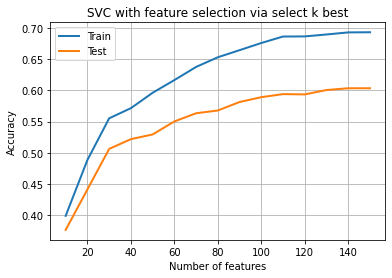

In [6]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(top_ns[:len(train_accuracies)], train_accuracies, linewidth=2.0, label='Train')
ax.plot(top_ns[:len(test_accuracies)], test_accuracies, linewidth=2.0, label='Test')
ax.set_title("SVC with feature selection via select k best")
ax.set_xlabel("Number of features")
ax.set_ylabel("Accuracy")
ax.legend()
ax.grid()
fig.show()



---

# SVC with dimensionality reduction

## Experiment \#5: SVC with PCA

In [7]:
"""
Use PCA to perform dimensionality reduction
"""

from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

n_components_list = np.arange(10, 510, 10)
train_accuracies = []
test_accuracies = []

for n_components in n_components_list:

  pca = PCA(n_components)
  X_train_pca = pca.fit_transform(X_train)
  X_test_pca = pca.transform(X_test)

  clf = SVC(max_iter=100000, class_weight='balanced')
  clf.fit(X_train_pca, y_train)

  train_accuracy = accuracy_score(y_train, clf.predict(X_train_pca))
  train_accuracies.append(train_accuracy)
  test_accuracy = accuracy_score(y_test, clf.predict(X_test_pca))
  test_accuracies.append(test_accuracy)

  print(F"Using {n_components} components from PCA...")
  print(F"Train accuracy: {train_accuracy}")
  print(F"Test accuracy:  {test_accuracy}")
  if train_accuracy > (test_accuracy+0.05):
    print(F"Overfitting detected!")
    if tolerance == 0:
      break
    tolerance -= 1
  else:
    tolerance = 10
  print(F"-"*100)

Using 10 components from PCA...
Train accuracy: 0.4800351288056206
Test accuracy:  0.46850854600796066
----------------------------------------------------------------------------------------------------
Using 20 components from PCA...
Train accuracy: 0.542096018735363
Test accuracy:  0.519082182158745
----------------------------------------------------------------------------------------------------
Using 30 components from PCA...
Train accuracy: 0.5936182669789227
Test accuracy:  0.5565441348630298
----------------------------------------------------------------------------------------------------
Using 40 components from PCA...
Train accuracy: 0.6244730679156909
Test accuracy:  0.5675485834699133
Overfitting detected!
----------------------------------------------------------------------------------------------------
Using 50 components from PCA...
Train accuracy: 0.6562060889929743
Test accuracy:  0.5984546944509482
Overfitting detected!
-------------------------------------------

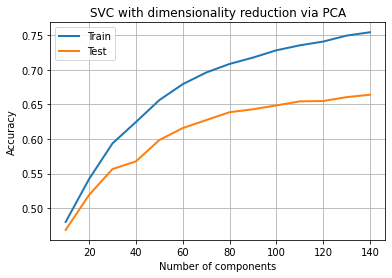

In [8]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(n_components_list[:len(train_accuracies)], train_accuracies, linewidth=2.0, label='Train')
ax.plot(n_components_list[:len(test_accuracies)], test_accuracies, linewidth=2.0, label='Test')
ax.set_title("SVC with dimensionality reduction via PCA")
ax.set_xlabel("Number of components")
ax.set_ylabel("Accuracy")
ax.legend()
ax.grid()
fig.show()

## Experiment \#6: Linear SVC with kernel PCA

In [9]:
"""
Use kernel PCA to perform dimensionality reduction
"""

from sklearn.decomposition import KernelPCA
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

n_components_list = np.arange(10, 2010, 10)
train_accuracies = []
test_accuracies = []

for n_components in n_components_list:

  kpca = KernelPCA(n_components=n_components, 
                   kernel='rbf', 
                   n_jobs=-1, 
                   random_state=10,
                   eigen_solver="randomized")
  X_train_kpca = kpca.fit_transform(X_train)
  X_test_kpca = kpca.transform(X_test)

  clf = SVC(max_iter=100000, class_weight='balanced')
  clf.fit(X_train_kpca, y_train)

  train_accuracy = accuracy_score(y_train, clf.predict(X_train_kpca))
  train_accuracies.append(train_accuracy)
  test_accuracy = accuracy_score(y_test, clf.predict(X_test_kpca))
  test_accuracies.append(test_accuracy)

  print(F"Using {n_components} components from kernel PCA...")
  print(F"Train accuracy: {train_accuracy}")
  print(F"Test accuracy:  {test_accuracy}")
  if train_accuracy > (test_accuracy+0.05):
    print(F"Overfitting detected!")
    if tolerance == 0:
      break
    tolerance -= 1
  else:
    tolerance = 10
  print(F"-"*100)

Using 10 components from kernel PCA...
Train accuracy: 0.5048009367681499
Test accuracy:  0.49121985483493324
----------------------------------------------------------------------------------------------------
Using 20 components from kernel PCA...
Train accuracy: 0.6012880562060889
Test accuracy:  0.5513931163661906
----------------------------------------------------------------------------------------------------
Using 30 components from kernel PCA...
Train accuracy: 0.6499414519906324
Test accuracy:  0.5895574806836806
Overfitting detected!
----------------------------------------------------------------------------------------------------
Using 40 components from kernel PCA...
Train accuracy: 0.6962529274004684
Test accuracy:  0.6185904940295013
Overfitting detected!
----------------------------------------------------------------------------------------------------
Using 50 components from kernel PCA...
Train accuracy: 0.7214285714285714
Test accuracy:  0.6328728634980099
Overfi

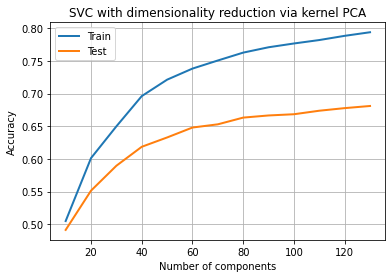

In [10]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(n_components_list[:len(train_accuracies)], train_accuracies, linewidth=2.0, label='Train')
ax.plot(n_components_list[:len(test_accuracies)], test_accuracies, linewidth=2.0, label='Test')
ax.set_title("SVC with dimensionality reduction via kernel PCA")
ax.set_xlabel("Number of components")
ax.set_ylabel("Accuracy")
ax.legend()
ax.grid()
fig.show()